[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ArtIC-TITECH/b3-proj-2023/blob/main/docs/class_01.ipynb)

# ニューラルネットワークを用いたMNISTデータセットの学習

## 目次

1. ニューラルネットワークを用いた線形関数の近似
2. 全結合層を使った手書き文字認識
3. 畳み込み層を使った手書き文字認識

## 1. ニューラルネットワークを用いた線形関数の近似

ニューラルネットワークは、ChatGPTや画像生成AIなどの基盤となる技術です。  
その基本原理は、関数近似に基づいており、複雑な関数を近似できるのが特徴です。  
この章では、ニューラルネットワークで関数近似を行う簡単な例を紹介します。

ニューラルネットワークの学習は以下の流れで行います。
1. データセットの作成
1. モデルの作成
1. 損失関数、最適化関数の定義
1. モデルの学習
1. モデルの評価

本題に入る前に本日使用するライブラリをimportします。

In [126]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt

### 1-1.データセットの作成

ニューラルネットワークの学習に用いるデータセットを作成します。今回の例ではy=2x+1の関数近似をします。

In [127]:
a = 2  # 傾き
b = 1  # 切片
x_train = np.linspace(0, 9, 10)  # 0から10までの100個のデータ点を生成
y_train = a * x_train + b  # 真の線形関数

In [128]:
x_train

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [129]:
y_train

array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19.])

データ型をNumpyのarrayからPyTorchのtensorに変換します。PyTorchの処理の都合上、view(-1, 1)を使って形状を(10, 1)にします。

In [130]:
# Tensorに変換
x_train = torch.tensor(x_train, dtype=torch.float32).view(-1, 1)  # (10, 1) の形に
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # (10, 1) の形に

In [131]:
x_train

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]])

In [132]:
y_train

tensor([[ 1.],
        [ 3.],
        [ 5.],
        [ 7.],
        [ 9.],
        [11.],
        [13.],
        [15.],
        [17.],
        [19.]])

### 1-2.モデルの作成

ニューラルネットワークを作成します。  
self.linear=nn.Linear(入力サイズ, 出力サイズ)は(出力サイズ$\times$入力サイズ)の重み行列$\mathbf{A}$と(出力サイズ)のバイアスベクトル$b$を生成します。  
そして(入力サイズ)のベクトルxを入力した際、self.linear(x)は$\mathbf{A}x+b$を返します。  
今回は入力サイズも出力サイズも1なので$y=ax+b$とかけます。

In [133]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)  # 入力1、出力1の線形層
        init.constant_(self.linear.weight, 0)  # 重みaをすべて0に初期化
        init.constant_(self.linear.bias, 0)    # バイアスbをすべて0に初期化

    def forward(self, x):
        return self.linear(x)

# モデルのインスタンスを作成
model = LinearRegressionModel()

重みaとバイアスbをどちらも0にしたのでモデルはy=0x+0=0となり、入力に関わらず出力は0になります。

In [134]:
model(torch.Tensor([1]))

tensor([0.], grad_fn=<ViewBackward0>)

モデルが現在y=0x+0であることは以下のプロットで確認できます。

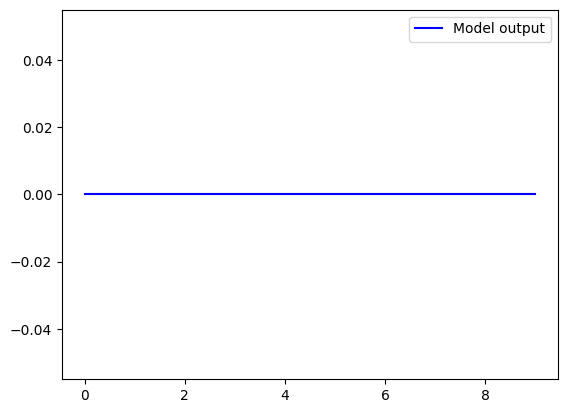

In [135]:
with torch.no_grad():
    predicted = model(x_train).detach().numpy()

plt.plot(x_train.numpy(), predicted, label='Model output', color='blue')
plt.legend()
plt.show()

###1-3. 損失関数, 最適化関数の定義

詳細は後述しますが  
損失関数としてMSELoss (Mean squared error, 平均二乗誤差)を使用します。  
また最適化関数としてSGD (Stochastic gradient descent, 確率的勾配降下法)を使用します。

In [136]:
criterion = nn.MSELoss()  # 平均二乗誤差を損失関数として使用
optimizer = optim.SGD(model.parameters(), lr=0.01) # 確率的勾配降下法を最適化関数として使用

### 1-4. モデルの学習


モデルの学習で重要なのが損失関数と最適化関数です。

#### 損失関数について
平均二乗誤差を使ったlossはニューラルネットワークの出力y_pred=ax+bと正解データy_trainを用いて  
$\text{loss}=(\text{y_pred}-\text{y_train})^2=(ax+b-\text{y_train})^2$  
で計算されます。  
例としてx=1のときy=2x+1の正解データはy_train=3です。しかしモデルの出力はy_pred=0だったとします。このときlossは$\text{loss}=(0-3)^2=9$となります。モデルはlossができるだけ小さくなるように学習を行います。

#### 最適化関数について
lossを小さくするために、モデルは$y=ax+b$の$a$と$b$をそれぞれ大きくするべきか、小さくするべきか知りたいです。これを知るためにlossをaやbで微分した結果が役立ちます。  
$$
\frac{\partial\text{loss}}{\partial{a}}=2(ax+b-\text{y_train})x
$$
が0より大きい場合、aを増やすとlossも大きくなります。反対に0より小さい場合、aを減らすとlossが大きくなります。  
したがって$\lambda(>0)$を微小量として以下のようにaを更新します。
$$
a = a-\lambda\frac{\partial\text{loss}}{\partial{a}}
$$
$\lambda$は最適化関数を定義する際にlrで指定します。  
optimizer = optim.SGD(model.parameters(), lr=0.01)

#### 損失と勾配の確認

実際にy=0x+0にx=1を入れた際の損失と勾配を確認します。
近似したい関数はy=2x+1だとします。

In [137]:
# x=1とします
x = torch.Tensor([1])

# モデルの予測
y = model(x)
y

tensor([0.], grad_fn=<ViewBackward0>)

損失関数  
$\text{loss}=(\text{y_pred}-\text{y_train})^2=(ax+b-\text{y_train})^2$  
は以下のコードで計算できます。

In [138]:
# lossの表示
loss = criterion(y, 2*x+1)
loss

tensor(9., grad_fn=<MseLossBackward0>)

lossに対するaの勾配
$$
\frac{\partial\text{loss}}{\partial{a}}
$$
は以下のコードで計算できます。

In [139]:
# 勾配の計算
loss.backward()

# aの勾配の表示
print(model.linear.weight.grad)

tensor([[-6.]])


#### 学習の実行

上記の損失関数と最適化関数でaとbの更新を5回行います。

In [140]:
epochs = 5
for epoch in range(epochs):
    # モデルの予測
    y_pred = model(x_train)

    # 損失の計算
    loss = criterion(y_pred, y_train)

    # 勾配の初期化
    optimizer.zero_grad()

    # バックプロパゲーション
    loss.backward()

    # 重みの更新
    optimizer.step()

    # 損失を表示
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 133.0000
Epoch [2/5], Loss: 23.0816
Epoch [3/5], Loss: 4.0907
Epoch [4/5], Loss: 0.8086
Epoch [5/5], Loss: 0.2404


### 1-5. モデルの評価

y=2x+1に近いモデルが得られました。

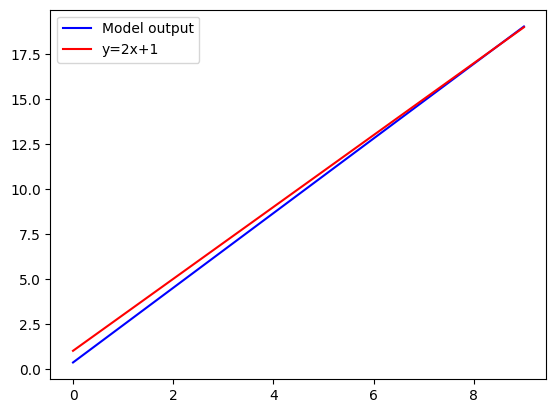

In [143]:
with torch.no_grad():
    predicted = model(x_train).detach().numpy()

plt.plot(x_train.numpy(), predicted, label='Model output', color='blue')
plt.plot(x_train.numpy(), y_train.numpy(), label='y=2x+1', color='red')
plt.legend()
plt.show()

## CIFAR-10データローダーの作成

### CIFAR-10とは

- 合計で6万枚のRGB画像(32x32)を含むデータセット
- クラス数は10クラス(各クラス学習用5000枚、評価用1000枚)

### データセットの作成

pytorchでは、torchvisionのライブラリを使用することで`torchvision.datasets.CIFAR10`のように事前に決められた[データセット](https://pytorch.org/vision/0.8/datasets.html)を使用することができます。

`root`はデータセットを保存するパスを指定します。
今回は`path`という変数を使用しているため、`path`を書き換えることでデータの保存先を各自変更してください。
例えば、Google Driveの配下の`b3_proj_2023/data`に学習用データを保存する場合は`path`を
```python
path = "./drive/My Drive/Colab Notebooks/b3_proj_2023/data"
```
のように変更します。
(このように自身のGoogle Drive上に保存することで次回以降にデータを再度ダウンロードする必要がなくなるので便利です。)

`train=True|False`で学習データか評価データかを指定することができます。 \
また、`transform`でデータ変換やデータオーグメンテーションを指定することができます。
データ変換は複数同時に適用することがほとんどで、そのような場合は`transforms.Compose`を使用して複数のデータ変換を一連の処理として指定します。
```python
transform = transforms.Compose(
    [transforms.ToTensor(),
    ...
     ])
```
のようにpythonのリストで指定し、データを読み込む際に上から順番に実行されます。
適用可能な関数の一覧は[こちら](https://pytorch.org/vision/main/transforms.html)を参照してください。

## データローダーの作成

データセットに含まれるデータ数は非常に大きく、一度にメモリに読み込むことは難しい場合が多いです。\
そのため、そこで一度に読み出すデータの数を減らすことで計算負荷を減らしています。\
これをミニバッチと呼び、ロードするデータ数をバッチサイズと呼びます。

pytorchでは、こうしたバッチ処理を`DataLoader`というクラスを用いて行います。\
`DataLoader`は`batch_size`という引数で一度に読み出すデータの数を指定することができます。

In [141]:
## Please update the path to your own directory.
# path=/path/to/your_own  # Uncomment this line
path = '../../work/data/cifar10'

## Define Augmentation
transform = transforms.Compose(
    [transforms.ToTensor(),
     ])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root=path, train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=path, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

NameError: name 'transforms' is not defined

### データセット・データローダーの確認

先ほどのデータセットにどのようなデータが保存されているのか確認します。

`images`は$[B\times 3\times 32\times 32]$のテンソルでモデルの入力に使用します。\
また、`labels`は$[B]$のテンソルで学習のラベルとして使われます。ここで、$B$はバッチサイズを表します。

下のセルを実行すると変数`batch_size`で指定した数と同じ枚数の画像が出力されるのがわかるかと思います。

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
torch.manual_seed(15)

def imshow(imgs, labels):
    imgs = imgs / 2 + 0.5     # unnormalize
    npimg = imgs.numpy()
    for i, (img, label) in enumerate(zip(npimg, labels)):
        plt.subplot(1, batch_size, i+1)
        plt.grid(False)
        plt.imshow(np.transpose(img, (1, 2, 0)))
        label = label.item()
        plt.title(f"{classes[label]}({label})")

    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(images, labels)
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 演習

- データ変換に正規化を追加してください。
- バッチサイズを4に変更した場合に出力がどう変化するか確認してください。
- ランダムに上下を反転させるデータ変換を追加してください。(任意)

## モデルの作成
ここでは、推論に使用するモデルの作成を行います。

モデルを作成する前にニューラルネットワークで広く用いられるモデルの構成要素について簡単に説明します。

### 全結合層
<img src="https://github.com/ArtIC-TITECH/b3-proj-2023/blob/main/resources/class_01/fully_connected.png?raw=1" width="10%">

全結合層とは、入力と出力が全て重みによって結合されている層を指します。\
図では、一次元で表していますが、`pytorch`ではバッチ処理が行われるため実際は2次元の入力に対して処理が行われます。\
そのため、入力$\mathbf{x} \in \mathbb{R}^{B\times C_{\rm in}}$に対して、重み$W\in\mathbb{R}^{C_{\rm in}\times C_{\rm out}}$とバイアス$\mathbf{B} \in \mathbb{R}^{B\times C_{\rm out}}$を用いて出力$y\in\mathbb{R}^{B\times C_{\rm out}}$は次のように計算されます。
$$\mathbf{y} = \mathbf{x}\mathbf{W} + \mathbf{B}$$
ここで、$B$はバッチサイズ、$C_{\rm in}$、$C_{\rm out}$は入力チャネル、出力チャネル数を表しています。

`pytorch`では`nn.Linear`というクラスで実装されています。\
`in_features`で入力のチャネル数、`out_features`で出力のチャネル数を指定します。

例えば、入力チャネルが$4$、出力チャネルが$10$の全結合層は次のように実装します。

In [ ]:
import torch.nn as nn
input = torch.rand((4, 3))
print(f'Input Shape is {input.shape}')
linear = nn.Linear(in_features=3, out_features=10)
output = linear(input)
print(f'Output Shape is {output.shape}')

演習
上のセルを修正して入力チャネルが5、出力チャネルが15の線形層を`nn.Linear`を用いて実装してください。\
このとき、入力のバッチサイズを4とし、線形層の入力チャネルと入力データのチャネル数を揃える必要があることに注意してください。


### 畳み込み層
<img src="https://github.com/ArtIC-TITECH/b3-proj-2023/blob/main/resources/class_01/conv1d.png?raw=1" width="30%">

全結合層では全ての入力チャネルと出力チャネルが重みで結合されていたのに対し、畳み込み層では入力に対してカーネルをストライドさせることで出力を計算します。\
そのため、出力のサイズは、カーネルサイズ、ストライド、パディングによって決定されます。\
画像では1次元のデータに対する1次元の畳み込みを例にしていますが、画像のデータセットでは4次元の入力に対し2次元の畳み込みを行うことが一般的です。\
この場合カーネルは$[C_{\rm out}, C_{\rm in}, k_{\rm h}, k_{\rm w}]$の4次元のテンソルで定義され、このカーネルを画像の縦横方向にストライドさせることで計算を行います。

例えば、入力サイズが$[4, 3, 10, 10]$のデータに対して、出力チャネル6、カーネルサイズ3、パディングおよびストライドが1の畳み込みは次のように実装されます。

In [ ]:
import torch.nn as nn
input = torch.rand((4, 3, 10, 10))
print(f'Input Shape is {input.shape}')
conv2d = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=1, stride=1)
output = conv2d(input)
print(f'Output Shape is {output.shape}')

演習
上のセルを修正して入力チャネルが5、出力チャネルが10のカーネルサイズが5、パディングが0、ストライドが1のConvを実装してください。\
このとき、入力のバッチサイズを4とし、入力チャネルと入力データのチャネル数を揃える必要があることに注意してください。\
出力のサイズが変化していることを確認してください。

### プーリング層

プーリング層は畳み込み層と同様にカーネルを画像の$H$、$W$方向に動かしながら処理を行いますが、次の2点で畳み込み層と異なります。
- チャネル間の情報を集約しない
- カーネルは重みではなく決まった処理が行われる
    - MaxPool2dでは、カーネル内の最大値が出力される
    - AvgPool2dでは、カーネル内の平均値が出力される

例えば、カーネルサイズ$2$、ストライド$2$のMaxPool2dは次のように使用します。\
入出力を比較すると$2\times2$のカーネルの中から最大値が選ばれていることがわかります。

In [ ]:
import torch.nn as nn
input = torch.rand((4, 3, 8, 8))
print(input[0][0])
pool = nn.MaxPool2d(kernel_size=2, stride=2)
output = pool(input)

print(output[0][0])

### 活性化関数
活性化関数とは、入力に対して非線形処理を適用しニューラルネットワークの表現力を向上させるために使用する関数です。

活性化関数には様々な種類がありますが、今回の演習では`ReLU`関数を非線形関数として用います。\
次のコードは入力に対して`ReLU`を適用したもので、$0$以下の入力が全て$0$となることがわかります。

In [ ]:
import matplotlib.pyplot as plt
import torch.nn as nn

input = torch.randn(100,)
act = nn.ReLU()
output = act(input)
plt.plot(input.sort().values, output.sort().values)

ここまでで説明した4つの構成要素を用いてニューラルネットワークは次のように実装されます。\
ここでは、畳み込み1層、プーリング層1層、全結合層1層のニューラルネットワークを実装しています。

In [ ]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.act = nn.ReLU()
        self.fc1 = nn.Linear(in_features=6*14*14, out_features=10)

    def forward(self, x):
        x = self.pool(self.act(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

### 実際にモデルを動かしてみよう

ここでは乱数を入力としてモデルを動かしてみます。
ニューラルネットワークは、入力サイズ$(B, C, H, W)$のテンソルを入力として、$(B, \rm{Cls})$を出力とします。\
ここで$B$はバッチサイズ、$C$は入力チャネル数(RGB画像の場合は3チャネル)、$H$, $W$は画像の幅と高さになります。CIFAR-10データセットの場合は、$H=W=32$です。\
$\rm{Cls}$は出力のクラス数を表し、CIFAR-10は10クラスを出力します。\
ここでは、$(B, C, H, W) = (1, 3, 32, 32)$の乱数を入力としてモデルの推論を行います。\
実際にコードを実行すると(1, 10)の出力が得られると思います。出力の各要素がそれぞれのクラスの予測値となります。

In [ ]:
torch.manual_seed(100)

input = torch.rand((1, 3, 32, 32))
net = Net()
output = net(input)

print(output)

演習\
`Net`クラスを修正して以下で定義されるモデルを実装してください。\
Conv2dは全て`padding=0`、`stride=1`で、MaxPool2dは`stride=2`で実装してください。\
それぞれの層のカーネルサイズは、テーブルの`Kernel Shape`を元に決定してください。\
それぞれの層のチャネル数は、入力チャネル、出力チャネルを参考に実装してください。\
最終層以外のConv, Linear層の後には

```
===================================================================================================================
Layer (type:depth-idx)                   Input Shape               Output Shape              Kernel Shape
===================================================================================================================
Net                                      [4, 3, 32, 32]            [4, 10]                   --
├─Conv2d: 1-1                            [4, 3, 32, 32]            [4, 6, 28, 28]            [5, 5]
│    └─weight                                                                                [3, 6, 5, 5]
│    └─bias                                                                                  [6]
|-ReLU                                   [4, 6, 28, 28]            [4, 6, 28, 28]
├─MaxPool2d: 1-2                         [4, 6, 28, 28]            [4, 6, 14, 14]            2
├─Conv2d: 1-3                            [4, 6, 14, 14]            [4, 16, 10, 10]           [5, 5]
│    └─weight                                                                                [6, 16, 5, 5]
│    └─bias                                                                                  [16]
|-ReLU                                   [4, 16, 10, 10]           [4, 16, 10, 10]
├─MaxPool2d: 1-4                         [4, 16, 10, 10]           [4, 16, 5, 5]             2
├─Linear: 1-5                            [4, 400]                  [4, 120]                  --
│    └─weight                                                                                [400, 120]
│    └─bias                                                                                  [120]
|-ReLU                                   [4, 120]                  [4, 120]
├─Linear: 1-6                            [4, 120]                  [4, 84]                   --
│    └─weight                                                                                [120, 84]
│    └─bias                                                                                  [84]
|-ReLU                                   [4, 84]                   [4, 84]
├─Linear: 1-7                            [4, 84]                   [4, 10]                   --
│    └─weight                                                                                [84, 10]
│    └─bias                                                                                  [10]
===================================================================================================================
```



## 損失関数とオプティマイザの定義

損失関数$L$とはモデルの予測値と正解ラベルの誤差を計算するための関数です。\
損失関数は`CrossEntropyLoss`というラベルデータの確率分布と出力の確率分布の誤差を計算する関数が主に使用されます。\
また、オプティマイザーとはパラメータを更新するための関数で、画像認識では`SGD`や`Adam`などが広く使用されています。

今回の演習では、`SGD`をオプティマイザとして使用します。
`SGD`の第一引数は更新するパラメータを指定しています。\
第二引数は学習率と呼ばれ、一度に更新するパラメータの大きさを調整しています。\
`momentum`や、今回は使われていませんが`weight_decay`といった引数はニューラルネットワークの学習を安定させたり過学習を抑制するために使用します。

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### ニューラルネットワークの学習

では、先ほど定義した損失関数とoptimizerを使用して実際にニューラルネットワークの学習を行いましょう。\
最初に説明した通り、ニューラルネットワークの学習はミニバッチ学習と呼ばれるデータセットの一部のデータを使用してパラメータを更新する作業を繰り返し行います。\
データセット内の全てのデータが学習に使用されるイテレーションの数を1エポックと呼び、複数エポック学習することでパラメータの最適化を行います。\

各イテレーションでは、次の4つの処理を主に行います。
- モデルの推論(順伝播)
    - ミニバッチ入力に対してモデルが予測値を出力します。
- 損失の計算
    - モデルの予測値と正解ラベルの誤差を計算します。
- 勾配のリセット
    - 前のイテレーションでパラメータの更新に使用した勾配のリセット。
- 勾配の計算(逆伝播)
    - 損失を元に各パラメータの勾配計算を行います。
- パラメータの更新

In [ ]:
for epoch in range(2):
    running_loss = 0.
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # 1. forward
        outputs = net(inputs)
        # 2. compute loss
        loss = criterion(outputs, labels)

        # 3. reset parameter gradient
        optimizer.zero_grad()

        # 4. backward
        loss.backward()

        # 5. update parameters
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

### テストデータを使用した検証
では、先ほど学習したモデルを使用して新しい検証用データに対する精度を測ってみましょう。

まずは、評価に使うデータをテストデータセットからロードします。

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(images, labels)
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

先ほどロードしたデータを用いて推論を行います。

In [ ]:
with torch.no_grad(): # Gradient計算を無効にします
    outputs = net(images)

予測結果を出力してみましょう。

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

結果はどうでしたか。
次は、テストデータセットを全て用いて精度を確認しましょう。

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

クラスごとの精度も確認してみましょう。
どのクラスの精度が一番高かったですか。

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

学習したモデルは、次のように保存することができます。

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

保存したモデルは次のようにすることで、保存したパラメータを使用することができます。

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

最後に学習をGPUを用いて行うように変更します。\
GPUを使用して学習するためには、モデルとデータをGPUに送る必要があります。

まずは、GPUが使用可能か確認します。
次のコードで`False`という結果が出たらGoogle Colaboratoryのランタイムを`GPU`に変更してみてください。

In [ ]:
print(torch.cuda.is_available())

GPUが使用可能であることがわかったら、モデルとデータをGPUで利用できるようにします。
まず、deviceという変数を一番初めのpythonセルに追加してください。

```python
## Pytorch関連ライブラリ
import torch
import torchvision
import torchvision.transforms as transforms

device = 'cuda:0' # 0番目のGPUをdeviceとして指定
```

モデルの定義部分と、入力及びラベルデータを次のように変更してください。

```python
net = Net()
net = net.to(device)
```

```python
# inputs, labels = data
inputs, labels = data[0].to(device), data[1].to(device)
```

## 宿題
**課題1**: VGG11を実装して評価してください。\
(**課題2**): データ拡張、モデルなどを変更してCIFAR-10の精度を向上させてください。

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt

# 1. データセットの作成 (y = ax + b)
a = 2  # 傾き
b = 3  # 切片
x_train = np.linspace(0, 10, 100)  # 0から10までの100個のデータ点を生成
y_train = a * x_train + b  # 真の線形関数

# Tensorに変換
x_train = torch.tensor(x_train, dtype=torch.float32).view(-1, 1)  # (100, 1) の形に
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # (100, 1) の形に

# 2. ニューラルネットワークの定義
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)  # 入力1、出力1の線形層
        init.constant_(self.linear.weight, 0)  # 重みをすべて0に初期化
        init.constant_(self.linear.bias, 0)    # バイアスをすべて0に初期化

    def forward(self, x):
        return self.linear(x)

# モデルのインスタンスを作成
model = LinearRegressionModel()

# 3. 損失関数とオプティマイザの定義
criterion = nn.MSELoss()  # 平均二乗誤差を損失関数として使用
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 4. モデルのトレーニング
epochs = 5
for epoch in range(epochs):
    # モデルの予測
    y_pred = model(x_train)

    # 損失の計算
    loss = criterion(y_pred, y_train)

    # 勾配の初期化
    optimizer.zero_grad()

    # バックプロパゲーション
    loss.backward()

    # 重みの更新
    optimizer.step()

    # 100エポックごとに損失を表示
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# 5. 結果の可視化
# 訓練済みモデルによる予測
with torch.no_grad():
    predicted = model(x_train).detach().numpy()

# 元のデータとモデルの予測をプロット
plt.plot(x_train.numpy(), y_train.numpy(), label='Original Data', color='blue')
plt.plot(x_train.numpy(), predicted, label='Fitted Line', color='red')
plt.legend()
plt.show()
